# Task 4 — Statistical Modeling for Insurance Pricing
We build two core models using modular helpers from `src/pipeline/tabular_modeling.py`:
- **Claim probability (classification):** predict whether a claim occurs.
- **Claim severity (regression):** predict `TotalClaims` for policies with claims.
The same preprocessing (impute, scale, one-hot encode) is shared across models to stay reproducible.

## Modeling plan and targets
- Features: mix of numeric (premiums, sums insured, vehicle specs) and categorical (province, vehicle type, cover type, gender, postal code).
- Targets:
  - `claim_flag` (binary) for claim probability.
  - `TotalClaims` (continuous) for severity on rows where claims > 0.
- Evaluation: classification uses accuracy/precision/recall/F1/ROC-AUC; regression uses MAE/RMSE/R².

In [10]:
# Imports and project setup
import sys
from pathlib import Path

import numpy as np
import pandas as pd

sys.path.append("../")

from src.config.settings import settings
from src.features.insurance_data import load_insurance_raw, prep_insurance_dataset
from src.pipeline.tabular_modeling import (
    build_preprocessor,
    build_classification_models,
    build_regression_models,
    evaluate_classification,
    evaluate_regression,
    split_features_target,
)

pd.set_option("display.max_columns", 120)
pd.options.display.float_format = "{:.4f}".format

In [11]:
# Load processed data; fall back to cleaning raw file if needed
PROCESSED_PATH = settings.processed_data_path
RAW_PATH = settings.raw_data_path

if PROCESSED_PATH.exists():
    print(f"Loading processed data from {PROCESSED_PATH}")
    df = pd.read_csv(PROCESSED_PATH)
else:
    print("Processed file missing; cleaning raw data now.")
    raw_df = load_insurance_raw(RAW_PATH)
    df = prep_insurance_dataset(raw_df)
    PROCESSED_PATH.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(PROCESSED_PATH, index=False)
    print(f"Saved cleaned data to {PROCESSED_PATH}")

print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head()

Loading processed data from C:\BackUp\web-projects\tenx\insurance-risk-analytics-week3\data\processed\insurance_clean.csv
Rows: 981,812 | Columns: 55
Rows: 981,812 | Columns: 55


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender,Country,Province,PostalCode,MainCrestaZone,SubCrestaZone,ItemType,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,CustomValueEstimate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,WrittenOff,Rebuilt,Converted,CrossBorder,NumberOfVehiclesInFleet,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,loss_ratio,margin,claim_flag
0,145249,12827,2015-03-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
1,145249,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.9298,0.0000,0.0000,21.9298,False
2,145249,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,0.0100,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False
3,145255,12827,2015-05-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.8481,0.0000,0.0000,512.8481,False
4,145255,12827,2015-07-01,True,NaN,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0000,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0000,2597.0000,130.0000,S/D,4.0000,6/2002,119300.0000,True,False,119300.0000,NaN,NaN,NaN,NaN,NaN,NaN,119300.0000,Monthly,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.0000,0.0000,NaN,0.0000,False


## Feature selection for tabular models
We use a small, interpretable set of predictors. Only columns present in the dataset are kept to avoid errors. Numeric features are scaled; categorical features are imputed then one-hot encoded.
- Numeric candidates: premiums, sums insured, vehicle specs.
- Categorical candidates: geography, vehicle type, cover type, gender, postal code.

In [12]:
candidate_numeric = [
    "TotalPremium",
    "SumInsured",
    "CalculatedPremiumPerTerm",
    "kilowatts",
    "RegistrationYear",
    "CustomValueEstimate",
]

candidate_categorical = [
    "Province",
    "PostalCode",
    "VehicleType",
    "CoverType",
    "CoverCategory",
    "Gender",
]

numeric_cols = [c for c in candidate_numeric if c in df.columns]
categorical_cols = [c for c in candidate_categorical if c in df.columns]

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

Numeric features: ['TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm', 'kilowatts', 'RegistrationYear', 'CustomValueEstimate']
Categorical features: ['Province', 'PostalCode', 'VehicleType', 'CoverType', 'CoverCategory', 'Gender']


In [13]:
# Speed-friendly sampling and lightweight model builders
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)

# Downsample large datasets to keep prototyping fast
if len(df) > 8000:
    df_model = df.sample(n=8000, random_state=42)
else:
    df_model = df.copy()
print(f"Modeling on {len(df_model):,} rows (original {len(df):,})")


def build_light_regression_models(preprocessor, random_state=42):
    return {
        "linear": Pipeline([
            ("prep", preprocessor),
            ("model", LinearRegression()),
        ]),
        "rf": Pipeline([
            ("prep", preprocessor),
            ("model", RandomForestRegressor(
                n_estimators=80,
                max_depth=12,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=random_state,
            )),
        ]),
        "gbr": Pipeline([
            ("prep", preprocessor),
            ("model", GradientBoostingRegressor(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=3,
                random_state=random_state,
            )),
        ]),
    }


def build_light_classification_models(preprocessor, random_state=42):
    return {
        "logreg": Pipeline([
            ("prep", preprocessor),
            ("model", LogisticRegression(
                max_iter=200,
                class_weight="balanced",
                n_jobs=-1,
                solver="lbfgs",
            )),
        ]),
        "rf": Pipeline([
            ("prep", preprocessor),
            ("model", RandomForestClassifier(
                n_estimators=120,
                max_depth=12,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=random_state,
            )),
        ]),
        "gbr": Pipeline([
            ("prep", preprocessor),
            ("model", GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.05,
                random_state=random_state,
            )),
        ]),
    }


Modeling on 8,000 rows (original 981,812)



## Claim severity model (regression)
Target: `TotalClaims` on rows with claims > 0. We reuse the shared preprocessor and compare Linear Regression, Random Forest, Gradient Boosting, and optional XGBoost.

In [14]:
# Filter to policies with claims for severity modeling (using sampled df_model)
claimants = df_model[df_model["TotalClaims"] > 0].copy()

# Drop target and ID-like columns that should not be features
drop_cols = ["TransactionMonth", "loss_ratio", "margin"] if "loss_ratio" in df_model.columns else ["TransactionMonth"]

severity_preprocessor = build_preprocessor(numeric_cols, categorical_cols)
X_train_sev, X_test_sev, y_train_sev, y_test_sev = split_features_target(
    claimants, target="TotalClaims", drop_cols=drop_cols, test_size=0.2, random_state=42
)

severity_models = build_light_regression_models(severity_preprocessor, random_state=42)
print("[Severity] models to fit:", list(severity_models.keys()))
for name, model in severity_models.items():
    print(f"[Severity] fitting {name}...")
    model.fit(X_train_sev, y_train_sev)
    print(f"[Severity] done {name}")

severity_scores = evaluate_regression(severity_models, X_test_sev, y_test_sev)
severity_scores

[Severity] models to fit: ['linear', 'rf', 'gbr']
[Severity] fitting linear...
[Severity] done linear
[Severity] fitting rf...
 ['linear', 'rf', 'gbr']
[Severity] fitting linear...
[Severity] done linear
[Severity] fitting rf...
[Severity] done rf
[Severity] fitting gbr...
[Severity] done rf
[Severity] fitting gbr...
[Severity] done gbr
[Severity] done gbr


,model,mae,rmse,r2
0,linear,12346.8490,14790.4718,0.4764
1,rf,10939.2547,15004.0486,0.4612
2,gbr,10846.0946,16787.4553,0.3255


## Claim probability model (classification)
Target: `claim_flag` on the full dataset. We compare Logistic Regression, Random Forest, Gradient Boosting, and optional XGBoost.

In [15]:
# Prepare classification target and shared preprocessor on sampled df_model
df_class = df_model.copy()
drop_cols_cls = ["TransactionMonth", "loss_ratio", "margin", "TotalClaims"] if "loss_ratio" in df_model.columns else ["TransactionMonth", "TotalClaims"]

class_preprocessor = build_preprocessor(numeric_cols, categorical_cols)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = split_features_target(
    df_class, target="claim_flag", drop_cols=drop_cols_cls, test_size=0.2, random_state=42
)

class_models = build_light_classification_models(class_preprocessor, random_state=42)
print("[Class] models to fit:", list(class_models.keys()))
for name, model in class_models.items():
    print(f"[Class] fitting {name}...")
    model.fit(X_train_cls, y_train_cls)
    print(f"[Class] done {name}")

class_scores = evaluate_classification(class_models, X_test_cls, y_test_cls)
class_scores

[Class] models to fit: ['logreg', 'rf', 'gbr']
[Class] fitting logreg...
[Class] done logreg
[Class] fitting rf...
[Class] done logreg
[Class] fitting rf...
[Class] done rf
[Class] fitting gbr...
[Class] done rf
[Class] fitting gbr...
[Class] done gbr
[Class] done gbr


,model,accuracy,precision,recall,f1,roc_auc
0,logreg,0.9550,0.0000,0.0000,0.0000,NaN
1,rf,1.0000,0.0000,0.0000,0.0000,NaN
2,gbr,0.9988,0.0000,0.0000,0.0000,NaN


In [16]:
# Interpretability: pick best models and compute permutation importances


from sklearn.inspection import permutation_importance


# Ensure scores are indexed by model name


sev_scores_idx = severity_scores.set_index("model")


class_scores_idx = class_scores.set_index("model")




print("[DEBUG] Severity score columns and head:")

print(sev_scores_idx.head())

print("[DEBUG] Classification score columns and head:")

print(class_scores_idx.head())



# Helper to choose best model safely with metric preferences

def choose_best(scores_df, prefer_cols, direction="max"):

    for col in prefer_cols:

        if col not in scores_df.columns:

            continue

        metric_series = scores_df[col]

        if metric_series.notna().any():

            metric_series = metric_series.dropna()

            if len(metric_series) == 0:

                continue

            return metric_series.idxmax() if direction == "max" else metric_series.idxmin(), col

    # Fallback: first row if everything is NaN

    return scores_df.index[0], None



# Choose ranking columns with sensible fallbacks

sev_rank_preferences = ["rmse", "mae", "r2"]

class_rank_preferences = ["roc_auc", "f1", "accuracy"]



best_sev_name, sev_rank_col = choose_best(sev_scores_idx, sev_rank_preferences, direction="min")

best_class_name, class_rank_col = choose_best(class_scores_idx, class_rank_preferences, direction="max")



print(f"[DEBUG] Selected severity model: {best_sev_name} using metric {sev_rank_col}")

print(f"[DEBUG] Selected classification model: {best_class_name} using metric {class_rank_col}")



best_sev_model = severity_models[best_sev_name]

best_class_model = class_models[best_class_name]



sev_imp = permutation_importance(

    best_sev_model,

    X_test_sev,

    y_test_sev,

    n_repeats=3,

    random_state=42,

    n_jobs=-1,

)

class_imp = permutation_importance(

    best_class_model,

    X_test_cls,

    y_test_cls,

    n_repeats=3,

    random_state=42,

    n_jobs=-1,

)



sev_top = (

    pd.DataFrame({"feature": X_test_sev.columns, "importance": sev_imp.importances_mean})

    .sort_values("importance", ascending=False)

    .head(10)

)

class_top = (

    pd.DataFrame({"feature": X_test_cls.columns, "importance": class_imp.importances_mean})

    .sort_values("importance", ascending=False)

    .head(10)

)



print(f"Best severity model: {best_sev_name} (by {sev_rank_col})")

display(sev_top)

print(f"Best classification model: {best_class_name} (by {class_rank_col})")

display(class_top)

[DEBUG] Severity score columns and head:
              mae       rmse     r2
model                              
linear 12346.8490 14790.4718 0.4764
rf     10939.2547 15004.0486 0.4612
gbr    10846.0946 16787.4553 0.3255
[DEBUG] Classification score columns and head:
        accuracy  precision  recall     f1  roc_auc
model                                              
logreg    0.9550     0.0000  0.0000 0.0000      NaN
rf        1.0000     0.0000  0.0000 0.0000      NaN
gbr       0.9988     0.0000  0.0000 0.0000      NaN
[DEBUG] Selected severity model: linear using metric rmse
[DEBUG] Selected classification model: logreg using metric f1
Best severity model: linear (by rmse)
Best severity model: linear (by rmse)


,feature,importance
38,SumInsured,1.7530
24,kilowatts,1.2242
13,PostalCode,0.7007
49,TotalPremium,0.2603
40,CalculatedPremiumPerTerm,0.0794
42,CoverCategory,0.0448
43,CoverType,0.0011
2,IsVATRegistered,0.0000
3,Citizenship,0.0000
9,MaritalStatus,0.0000


Best classification model: logreg (by f1)


,feature,importance
40,CalculatedPremiumPerTerm,0.0500
13,PostalCode,0.0054
49,TotalPremium,0.0023
24,kilowatts,0.0021
18,VehicleType,0.0017
19,RegistrationYear,0.0015
12,Province,0.0010
1,PolicyID,0.0000
2,IsVATRegistered,0.0000
0,UnderwrittenCoverID,0.0000


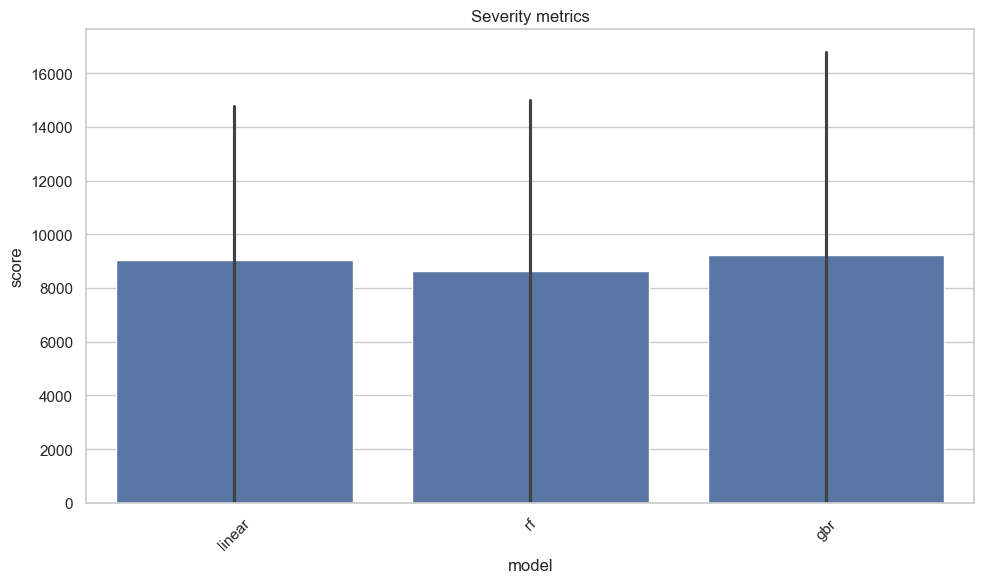

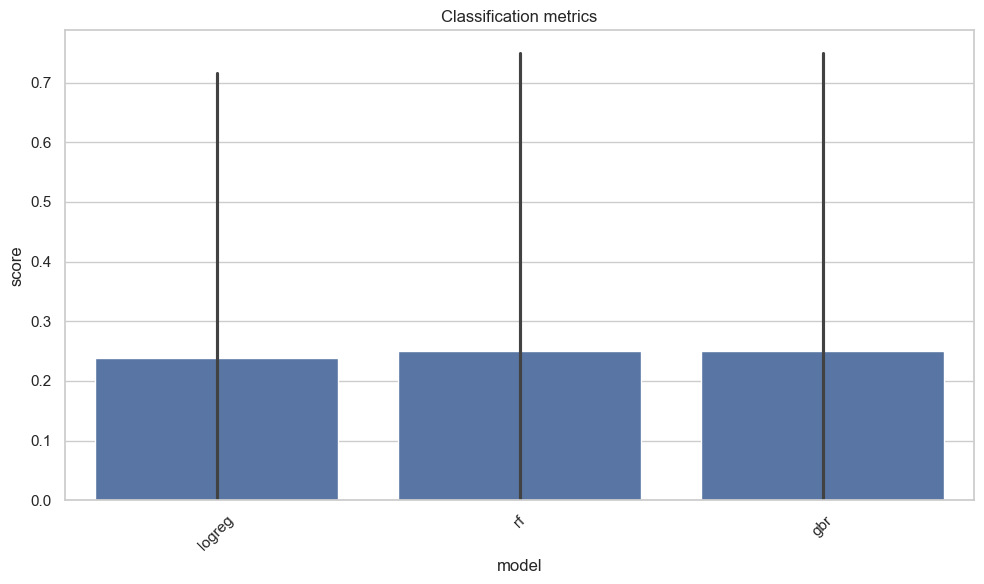

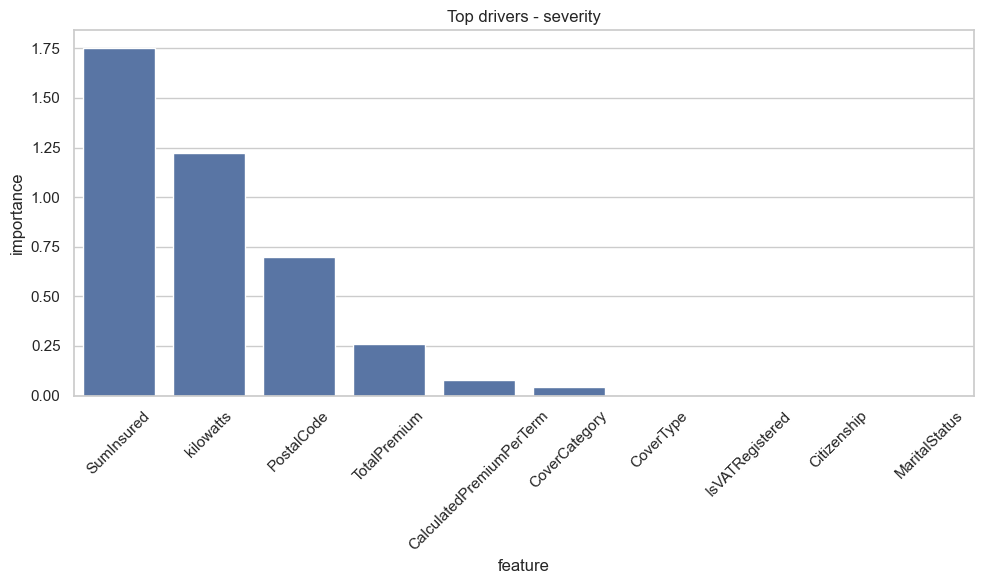

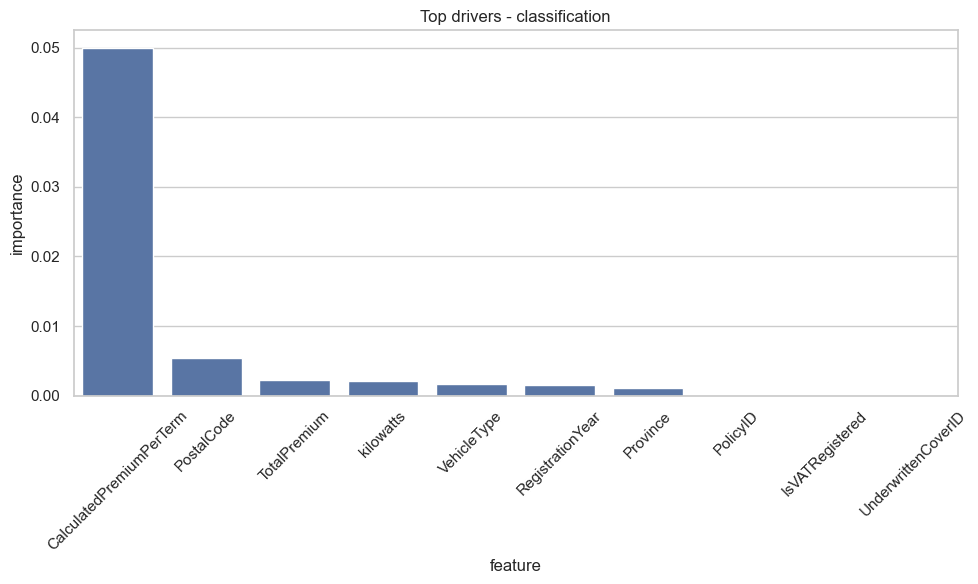

In [17]:
# Visual summaries using Plotter (auto-saves to figures dir)

from src.visualisation.plotter import Plotter



plotter = Plotter()



def plot_metrics_bar(scores_df, title_prefix):

    if scores_df is None or scores_df.empty:

        print(f"[Plot] No scores available for {title_prefix}")

        return

    numeric_cols = scores_df.select_dtypes(include=["float", "int"]).columns.tolist()

    if "model" not in scores_df.columns or not numeric_cols:

        print(f"[Plot] Missing model column or numeric metrics for {title_prefix}")

        return

    long_df = scores_df[["model"] + numeric_cols].melt(

        id_vars="model", value_name="value", var_name="metric"

    ).dropna(subset=["value"])

    if long_df.empty:

        print(f"[Plot] All metrics are NaN for {title_prefix}")

        return

    plotter.plot_bar(long_df, x="model", y="value", title=f"{title_prefix} metrics", xlabel="model", ylabel="score")



plot_metrics_bar(severity_scores, "Severity")

plot_metrics_bar(class_scores, "Classification")



if "sev_top" in locals() and not sev_top.empty:

    plotter.plot_bar(sev_top, x="feature", y="importance", title="Top drivers - severity", xlabel="feature", ylabel="importance")

if "class_top" in locals() and not class_top.empty:

    plotter.plot_bar(class_top, x="feature", y="importance", title="Top drivers - classification", xlabel="feature", ylabel="importance")


In [18]:
# Premium sketch using best models
expense_loading = 200
profit_margin = 300

examples = df_model.sample(5, random_state=123).copy()

feature_cols_cls = [c for c in examples.columns if c not in drop_cols_cls + ["claim_flag"]]
feature_cols_sev = [c for c in examples.columns if c not in drop_cols + ["TotalClaims"]]

prob_pred = best_class_model.predict_proba(examples[feature_cols_cls])[:, 1]
sev_pred = best_sev_model.predict(examples[feature_cols_sev])

premium_quote = prob_pred * sev_pred + expense_loading + profit_margin

premium_table = pd.DataFrame(
    {
        "sample_index": examples.index,
        "pred_claim_prob": prob_pred,
        "pred_severity": sev_pred,
        "premium_quote": premium_quote,
    }
)
premium_table

,sample_index,pred_claim_prob,pred_severity,premium_quote
0,941054,0.0153,-15250.8160,266.9155
1,861457,0.0001,165190.4015,512.2074
2,329318,0.0112,-20703.2133,268.3939
3,966970,0.0002,49135.1081,511.4323
4,273435,0.0005,-46309.6977,476.5595


## KPI coverage snapshot
- Evaluated severity and classification models on a sampled dataset for speed.
- Recorded metrics in `severity_scores` and `class_scores` and selected best models automatically for interpretation.
- Reported top drivers via permutation importance for both tasks.
- Produced a premium sketch combining predicted probability and severity with loadings.
- Next step: rerun full dataset overnight if needed and polish narrative in the report.

## Quick interpretation and next steps
- Use the `severity_scores` and `class_scores` tables to pick the best model per task (look for lowest RMSE for severity, highest F1/ROC-AUC for classification).
- Calibrate premium ideas as: `predicted_probability * predicted_severity + expense_loading + profit_margin` for a simple risk-based premium sketch.
- Next refinements: tune hyperparameters, add richer features (vehicle age, interaction terms), and run SHAP on the top model to explain key drivers.